In [159]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.linear_model import LogisticRegression
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [78]:
# configuration to see all columns
pd.set_option('display.max_columns', None)

In [79]:
# Reading data
data = pd.read_csv('NF-CSE-CIC-IDS2018-v2.csv')

In [80]:
#quick analyze
data.head()

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,CLIENT_TCP_FLAGS,SERVER_TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,MAX_TTL,LONGEST_FLOW_PKT,SHORTEST_FLOW_PKT,MIN_IP_PKT_LEN,MAX_IP_PKT_LEN,SRC_TO_DST_SECOND_BYTES,DST_TO_SRC_SECOND_BYTES,RETRANSMITTED_IN_BYTES,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,RETRANSMITTED_OUT_PKTS,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,NUM_PKTS_1024_TO_1514_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_QUERY_ID,DNS_QUERY_TYPE,DNS_TTL_ANSWER,FTP_COMMAND_RET_CODE,Label,Attack
0,13.58.98.64,40894,172.31.69.25,22,6,92.0,3164,23,3765,21,27,27,27,0,0,0,63,63,1028,52,52,1028,3164.0,3765.0,0,0,0,0,25312000,30120000,33,7,1,2,1,26883,26847,0,0,0,0,0,0,1,SSH-Bruteforce
1,213.202.230.143,29622,172.31.66.103,3389,6,0.0,1919,14,2031,11,223,219,30,0,0,0,101,101,1195,40,40,1195,1919.0,2031.0,0,0,0,0,15352000,16248000,17,6,0,1,1,8192,64000,0,0,0,0,0,0,0,Benign
2,172.31.66.5,65456,172.31.0.2,53,17,0.0,116,2,148,2,0,0,0,0,0,0,128,128,74,58,58,74,116.0,148.0,0,0,0,0,928000,1184000,4,0,0,0,0,0,0,0,0,2511,1,5,0,0,Benign
3,172.31.64.92,57918,172.31.0.2,53,17,0.0,70,1,130,1,0,0,0,0,0,0,0,0,130,70,70,130,70.0,130.0,0,0,0,0,560000,1040000,1,1,0,0,0,0,0,0,0,3371,1,60,0,0,Benign
4,18.219.32.43,63269,172.31.69.25,80,6,7.0,232,5,1136,4,223,222,27,4294827,140,0,127,127,1004,40,40,1004,232.0,1136.0,0,0,0,0,8000,9088000,8,0,0,1,0,8192,26883,0,0,0,0,0,0,1,DDoS attacks-LOIC-HTTP


In [81]:
data = data.drop(columns=['FTP_COMMAND_RET_CODE'])

In [82]:
#Can be removed
data = data[data.index % 40 == 0]

In [83]:
# Categorize labels by their damage
low = ['Benign', 'Brute Force -Web']
moderate = ['SSH-Bruteforce', 'FTP-BruteForce', 'Brute Force -XSS']
high = ['SQL Injection', 'DNS-TTL-ANSWER', 'DoS attacks-Slowloris']
severe = ['DDoS attacks-LOIC-HTTP', 'DDOS attack-HOIC', 'DoS attacks-Hulk', 'DDos attack-LOIC-UDP']
critical = ['DoS attacks-GoldenEye', 'DoS attacks-SlowHTTPTest', 'Infilteration', 'Bot']

In [84]:
# Create a mapper
mapper = {
    **dict(zip(low, ['low'] * len(low))),
    **dict(zip(moderate, ['moderate'] * len(moderate))),
    **dict(zip(high, ['high'] * len(high))),
    **dict(zip(severe, ['severe'] * len(severe))),
    **dict(zip(critical, ['critical'] * len(critical)))
}

In [85]:
# Rename labels
data['Attack'] = data['Attack'].replace(to_replace=mapper)

In [86]:
# Delete large value columns
large_columns = ['SRC_TO_DST_SECOND_BYTES', 'DST_TO_SRC_SECOND_BYTES']
data[large_columns] = np.log2(data[large_columns] + 1)

In [87]:
#Excluding label column
X, y = data.drop(columns=['Attack', 'Label']), data['Attack']

In [88]:
data = []

In [89]:
# Convert IP addresses into separate columns
ip_attrs = ['IPV4_SRC_ADDR', 'IPV4_DST_ADDR']
for i, attr in enumerate(ip_attrs):
    mapper = {j: f'{i}{j}' for j in range(4)}
    X = pd.concat([X, X[attr].str.split('.', expand=True).rename(columns=mapper).astype(int)], axis=1)

In [90]:
# Drop IP columns
X = X.drop(columns=ip_attrs)

In [91]:
#Categorizing columns
numeric_attrs = X.columns

In [92]:
# Preprocessing pipelines
num_transformer = Pipeline(steps=[('scaler', StandardScaler())])

In [93]:
# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_attrs),
    ]
)

In [94]:
# Complete pipeline with SMOTE
clf_pipeline = imbPipeline(steps=[
    ('preprocess', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('classifier', LogisticRegression(max_iter=500))
])

In [95]:
# Creating train and test sets
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_test, X_validation, y_test, y_validation = train_test_split(X_, y_, test_size=0.5, random_state=42, stratify=y_)

In [96]:
X_ = []
y_ = []

In [97]:
# Convert labels to numbers
le = LabelEncoder()
y = le.fit_transform(y)
y_train = le.transform(y_train)
y_validation = le.transform(y_validation)

In [98]:
# # Hyperparameter tuning
# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [None, 10, 20],
#     'classifier__min_samples_split': [2, 5],
#     'classifier__min_samples_leaf': [1, 2]
# }
# grid_search = GridSearchCV(clf_pipeline, param_grid, cv=3, n_jobs=-1)
# grid_search.fit(X_train, y_train)

In [99]:
# Evaluate best model
# best_clf = grid_search.best_estimator_
clf_pipeline.fit(X_train, y_train)
y_pred = clf_pipeline.predict(X_validation)
classification_report(y_validation, y_pred)

'              precision    recall  f1-score   support\n\n           0       1.00      1.00      1.00         5\n           1       0.12      0.88      0.21       747\n           2       0.59      1.00      0.74        24\n           3       1.00      0.88      0.94     41612\n           4       0.98      1.00      0.99       303\n           5       0.99      1.00      1.00      4544\n\n    accuracy                           0.90     47235\n   macro avg       0.78      0.96      0.81     47235\nweighted avg       0.98      0.90      0.93     47235\n'

In [100]:
X_validation = []
y_pred = []
y_validation = []

In [101]:
# Calculate scores via cross-validation
scores = cross_val_score(clf_pipeline, X, y, cv=5, scoring='recall_macro', n_jobs=-1)
print(f'Cross-Validation Recall Scores: {scores}')
print(f'Mean Recall: {scores.mean()}')

In [102]:
X = []
y = []

In [103]:
# Calculate probabilities
probabilities = clf_pipeline.predict_proba(X_test)
row_index = np.arange(len(probabilities))
probs = probabilities[row_index, le.transform(y_test)]

In [104]:
probabilities = []
X_test = []

In [105]:
# Group probabilties
bins = [0, 10, 40, 60, 90, 100]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
grouped_probs = pd.cut(probs * 100, bins=bins, labels=labels)

In [135]:
# Create Attack-Damage DataFrame
df = pd.concat([y_test.reset_index(drop=True), pd.Series(grouped_probs)], axis='columns')
df = df.rename(columns={0: 'Likelihood', 'Attack': 'Damage'})
df = pd.concat([df, pd.Series(np.ones(len(df)))], axis=1)

In [152]:
# Create risk Dataframe
risk_df = df.pivot_table(index='Damage', columns='Likelihood', values=0, aggfunc='sum')
index_order = ['low', 'moderate', 'high', 'severe', 'critical']
column_order = ['Very Low', 'Low', 'Medium', 'High', 'Very High']
risk_df = risk_df.reindex(columns=column_order, index=index_order)
num_risk_df = pd.DataFrame(np.array([[j for j in range(i, i + 5)] for i in range(1, 6)]), columns=column_order, index=index_order)

/var/folders/6n/6wjhkwk15sd82tg__mh1_78m0000gn/T/ipykernel_4954/1040045075.py:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  risk_df = df.pivot_table(index='Damage', columns='Likelihood', values=0, aggfunc='sum')


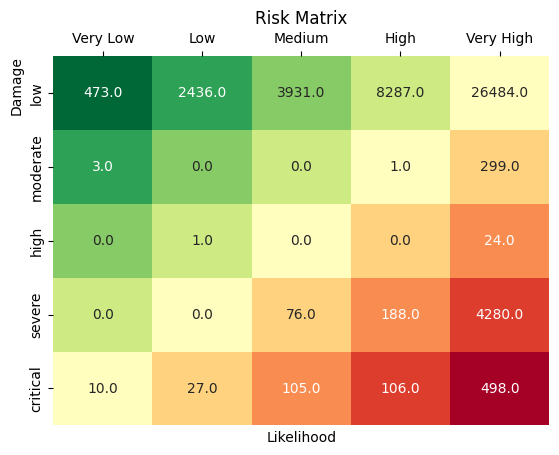

In [170]:
# Plot risk matrix
ax = sns.heatmap(num_risk_df, annot=risk_df, cmap='RdYlGn_r', cbar=False, fmt='')
ax.xaxis.tick_top()
ax.set_xlabel('Likelihood')
ax.set_ylabel('Damage')
plt.title('Risk Matrix')
plt.show()